In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import math
import random
import itertools
import datetime
from pytz import timezone
from sklearn.utils import shuffle

%matplotlib inline

Load preprocessed dataframes.

In [2]:
#Open our hdf files
test_store = pd.HDFStore('data/combined_day1_processed.h5')
pos_store1 = pd.HDFStore('data/processed/day1_positives_processed.h5')
neg_store1 = pd.HDFStore('data/processed/day1_negatives_processed.h5')
pos_store2 = pd.HDFStore('data/processed/day2_positives_processed.h5')
neg_store2 = pd.HDFStore('data/processed/day2_negatives_processed.h5')

#Load out dataframes
df_test = test_store['df']
df_pos1 = pos_store1['df'] 
df_neg1 = neg_store1['df']
df_pos2 = pos_store2['df'] 
df_neg2 = neg_store2['df']

#Close our hdf files
test_store.close()
pos_store1.close()
neg_store1.close()
pos_store2.close()
neg_store2.close()

#Shuffle dataframes
df_test = shuffle(df_test)
df_pos = shuffle(pd.concat([df_pos1, df_pos2]))
df_neg = shuffle(pd.concat([df_neg1, df_neg2]))

In [3]:
SAMPLE_SIZE = min(df_pos.shape[0], df_neg.shape[0])

In [7]:
df_train = pd.concat([df_pos.sample(SAMPLE_SIZE), df_neg.sample(SAMPLE_SIZE)])
df_train = shuffle(df_train)
df_test = shuffle(df_test.sample(int(0.3 * SAMPLE_SIZE)))

In [8]:
df_train.columns

Index(['_host', 'ad_network_id', 'advertiser_id', 'c_cnt', 'c_flag_cnt',
       'campaign_id', 'campaign_type', 'f_cnt', 'geo_city_name',
       'geo_country_code3', 'geo_region_name', 'geo_timezone', 'i_cnt',
       'i_flag_cnt', 'i_timestamp', 'pub_network_id', 'r_cnt',
       'r_num_ads_requested', 'r_num_ads_returned', 'r_timestamp',
       'rate_metric', 'referer', 'session_id', 'site_id', 'token', 'ua',
       'ua_device', 'ua_device_type', 'ua_major', 'ua_minor', 'ua_os_name',
       'url', 'user_agent', 'uuid', 'vi_cnt', 'vi_flag_cnt', 'url_domain',
       'red_domain', 'keywords'],
      dtype='object')

In [9]:
print(df_train.shape)
print(df_test.shape)
df_train.head()

(1252594, 39)
(187889, 39)


,_host,ad_network_id,advertiser_id,c_cnt,c_flag_cnt,campaign_id,campaign_type,f_cnt,geo_city_name,geo_country_code3,...,ua_minor,ua_os_name,url,user_agent,uuid,vi_cnt,vi_flag_cnt,url_domain,red_domain,keywords
807686,an-prod-ralphie-frontline-slugs.eu-west-1,1858.0,4568.0,0.0,0.0,22557.0,rtb,0.0,Calne,GBR,...,0.0,iOS,https://www.slantmagazine.com/games/review/fal...,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 like...,77eba13c-4671-46ee-b1fa-69ebceb82b3d,0.0,0.0,www.slantmagazine.com,,"[games, review, fallout]"
574531,an-prod-ralphie-frontline-allyl.us-east-1,2088.0,5187.0,0.0,0.0,26329.0,private,0.0,Orlando,USA,...,0.0,Windows 7,http://media.breitbart.com/media/if/newsmax.html,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,b2dda4b9-b0f7-4e8b-af58-6a4a4f81fd41,0.0,0.0,media.breitbart.com,www.breitbart.com,"[media, newsmax]"
233116,an-prod-ralphie-frontline-fleys.us-east-1,734.0,3167.0,1.0,0.0,20602.0,third-party,1.0,Central District,HKG,...,2.0,iOS,,Viber/8.5.0.6 CFNetwork/894 Darwin/17.4.0,26845BAB-7BE2-4503-8132-4ED039234858,1.0,0.0,,,[]
505930,an-prod-ralphie-frontline-fleys.us-east-1,267.0,2637.0,0.0,0.0,23983.0,private,1.0,Sinop,BRA,...,0.0,Android,https://www.pubgbr.com/762/modo-eventos-pistol...,Mozilla/5.0 (Linux; Android 5.1; ASUS_Z00VD Bu...,ed16c4c3-17d8-4789-939d-7d38afc663f8,0.0,0.0,www.pubgbr.com,,"[modo, eventos, pistola, sinalizacao, flare, gun]"
58828,an-prod-ralphie-frontline-lamed.us-east-1,1858.0,4568.0,0.0,0.0,22557.0,rtb,0.0,Bandung,IDN,...,0.0,iOS,https://www.makemac.com/tutorial-force-restart...,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 like...,1d721f2d-f5e6-4cd1-8460-7a8a73961d26,1.0,0.0,www.makemac.com,,"[tutorial, force, restart, dan, dfu, mode, iph..."


## One hot encoding of categorical data

In [10]:
import pickle

In [11]:
OHE_PATH = "data/ohe_labels.pkl"

In [83]:
#this is the helper function for preprocessing ohe labels - dont need to explicitly call this function
def generate_ohe_labels(df, c, thresh=200, k_most_freq=False):
    appears, oh_index = {}, {}
    if c == 'keywords':
        for val in df[c].values:
            for word in val:
                if word not in appears:
                    appears[word] = 0
                appears[word] += 1
        if k_most_freq:
            for v in sorted(appears)[0:thresh]:
                oh_index[v] = len(oh_index)
        else:
            for v in [k for k in appears.keys()]:
                if appears[v] < thresh:
                    del appears[v]
            for v in sorted(appears):
                oh_index[v] = len(oh_index)
    else:    
        for val in df[c].values:
            if val not in appears:
                appears[val] = 0
            appears[val] += 1
        if k_most_freq:
            for v in sorted(appears)[0:thresh]:
                oh_index[v] = len(oh_index)
        else:
            for v in [k for k in appears.keys()]:
                if appears[v] < thresh:
                    del appears[v]
            for v in sorted(appears):
                oh_index[v] = len(oh_index)
    return oh_index

#generate OHE labels to be used for batch learning - run this FIRST
def preprocess_ohe(df, thresh=200, path=OHE_PATH, k_most_freq=False):
    #create and save our ohe labels
    ohe_labels = {}
    for c in df:
        if c == 'c_cnt':
            continue
        else:
            ohe_labels[c] = generate_ohe_labels(df, c, thresh, k_most_freq=k_most_freq)

    with open(path, 'wb') as f:
        pickle.dump(ohe_labels, f, pickle.HIGHEST_PROTOCOL)
        
    return ohe_labels
        
#generates a small X and Y matrix by sampling from both negative and positive dataframes
def generate_batch(df_pos, df_neg, batch_size, path=OHE_PATH, pos_ratio=0.5, ohe_labels=None):
    #load our ohe labels
    if ohe_labels == None:
        with open(path, 'rb') as f:
            ohe_labels = pickle.load(path)
    
    #pick which indices to use for our batch training
    indices_touse_pos = np.random.permutation(len(df_pos))[0:int(pos_ratio * batch_size)]
    indices_touse_neg = np.random.permutation(len(df_neg))[0:int((1 - pos_ratio) * batch_size)]
    
    #generate X and Y matrices
    X, Y = [], []
    for i in range(len(indices_touse_pos)):
        sample_x, sample_y = generate_one_sample(df_pos, ohe_labels)
        X.append(sample_x)
        Y.append(sample_y)
    for i in range(len(indices_touse_neg)):
        sample_x, sample_y = generate_one_sample(df_neg, ohe_labels)
        X.append(sample_x)
        Y.append(sample_y)
    
    #shuffle X and Y matrices
    shuffled_indices = np.random.permutation(len(X))
    return [X[i] for i in shuffled_indices], [Y[i] for i in shuffled_indices]
    
#generates exactly one random sample from a dataframe using OHE. this is a helper function, shouldn't be explicitly called
#if index is not -1, will not generate random index
def generate_one_sample(df, ohe_labels, index=-1):
    if index == -1:
        index = np.random.randint(0,len(df))
    X = [[0 if ohe_labels[c][df[c].values[index]] != j else 1 for j in range(len(ohe_labels[c]))]
         if df[c].values[index] in ohe_labels[c] else [0 for j in range(len(ohe_labels[c]))]
                  for c in ohe_labels if c != 'c_cnt' and c != 'keywords']
    wordset = set([w for w in df['keywords'].values[index]])
    X.append([1 if v in wordset else 0 for v in ohe_labels['keywords']])
    X = np.array(X)
    X = np.hstack(X)
    return X, df['c_cnt'].values[index]

#takes in the dataframe, returns an X and Y matrix 
def transform_df(df, ohe_labels, thresh=200):
    data = np.vstack([generate_one_sample(df, ohe_labels, index=i)[0] for i in range(len(df))])
    X = data
    Y = df['c_cnt']
    return X, Y

#generate ohe labels
# ohe_labels = preprocess_ohe(df_neg, k_most_freq=False)
# #get validation set - take first 100,000 samples of both
# df_validate = pd.concat([df_neg.head(100000), df_pos.head(100000)])
# df_pos = df_pos.tail(len(df_pos)-100000)
# df_neg = df_neg.tail(len(df_neg)-100000)

In [158]:
# X_train, Y_train = transform_df(df_train, ohe_labels)
# X_test, Y_test = transform_df(df_test, ohe_labels)
X_validation, Y_validation = transform_df(df_test, ohe_labels, thresh=20)

KeyboardInterrupt: 

## Validation functions

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

def validate(model, df_validate):
    sigmoid = lambda x: 1/(1+2.71828**(-1*x))
    Y_test, Y_pred, Y_prob = [], [], []
    #Separate the validation dataframe into batches of 100
    for i in range(int(len(df_validate)/100)):
        X, Y = [], []
        for j in range(i*100,(i+1)*100):
            miniX, miniY = generate_one_sample(df_validate, ohe_labels, index=j)
            X.append(miniX)
            Y.append(miniY)
        Y_test.extend(Y)
        Y_pred.extend(model.predict(X))
        Y_prob.extend(model.decision_function(X))
    #apply sigmoid activation to all decision function values
    Y_prob = [sigmoid(i) for i in Y_prob]
    #get class probabilities based on Y_predict and Y_prob
    Y_prob = [[1-p, p] for i, p in enumerate(Y_prob)]
    #get log loss
    logloss = log_loss(Y_test, Y_prob)
    test_cm = confusion_matrix(Y_test, Y_pred)
    
    return logloss, test_cm

model = SGDClassifier(loss='log',penalty='l1',alpha=0.1)
X, Y = generate_batch(df_pos, df_neg, 100, ohe_labels=ohe_labels)
model.partial_fit(X, Y, classes=[0, 1])
for i in range(10000):
    X, Y = generate_batch(df_pos, df_neg, 100, ohe_labels=ohe_labels)
    if i % 10 == 0 and i != 0:
        train_cm = confusion_matrix(Y, model.predict(X))
        print("iteration ", i, "with training score ", model.score(X,Y))
        print("Training confusion matrix:")
        print(train_cm)
    if i % 10 == 0 and i != 0:
        logloss, test_cm = validate(model, df_validate)
        print("Log loss score: ", logloss)
        print("Test confusion matrix:")
        print(test_cm)
    model.partial_fit(X, Y)

NameError: name 'confusion_matrix' is not defined

## Scoring Functions

In [76]:
from sklearn.metrics import confusion_matrix

In [17]:
'''
We will be using f1 score to measure our models, which is a good performance measurement scalar for datasets
where the negatives >> positives.
'''
def get_f1_score(test_cm):
    true_neg  = test_cm[0][0]
    false_pos = test_cm[0][1]
    false_neg = test_cm[1][0]
    true_pos  = test_cm[1][1]
    precision = true_pos/(true_pos+false_pos)
    recall = true_pos/(true_pos+false_neg)
    if precision + recall == 0: return 0
    score = 2*precision*recall/(precision+recall)
    return score

'''
Returns (precision, recall)
'''
def cm_score(cm): 
    tn, fp, fn, tp = cm.ravel()
    return tp/(tp+fp), tp/(tp+fn)

## Random forest classifier to rank importance of numerical featuers

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
X, Y = generate_batch(df_pos, df_neg, 1000, ohe_labels=ohe_labels)
rfc = RandomForestClassifier()
rfc.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
X_train, Y_train = pd.DataFrame(X), pd.DataFrame(Y)

In [32]:
importances = rfc.feature_importances_
indices = np.argsort(importances)
print([list(ohe_labels.keys())[i] for i in indices])

IndexError: list index out of range

## XGBoost

In [96]:
import xgboost as xgb
from xgboost import plot_importance

In [147]:
X, Y = generate_batch(df_pos, df_neg, 7000, ohe_labels=ohe_labels, pos_ratio=0.5)
X_train_eq, Y_train_eq = pd.DataFrame(X), pd.DataFrame(Y)

X, Y = generate_batch(df_pos, df_neg, 7000, ohe_labels=ohe_labels, pos_ratio=0.1)
X_train_biased, Y_train_biased  = pd.DataFrame(X), pd.DataFrame(Y)

X, Y = generate_batch(df_pos, df_neg, 3000, ohe_labels=ohe_labels, pos_ratio=0.1)
X_test_biased, Y_test_biased  = pd.DataFrame(X), pd.DataFrame(Y)

X, Y = generate_batch(df_pos, df_neg, 3000, ohe_labels=ohe_labels, pos_ratio=(df_test.c_cnt.sum())/(len(df_test.c_cnt)))
X_test_same, Y_test_same  = pd.DataFrame(X), pd.DataFrame(Y)

In [148]:
dtrain_eq = xgb.DMatrix(X_train_eq, label=Y_train_eq)
dtrain_biased = xgb.DMatrix(X_train_biased, label=Y_train_biased)
dtest_biased = xgb.DMatrix(X_test_biased)
dtest_same = xgb.DMatrix(X_test_same)

In [149]:
# model: XGB model
# dtest: dmatrix (if XGB native model) or DataFrame (if sklearn api model)
# Y_test: Pandas Series of correct values
def score_xgboost(model, dtest, Y_test):
    cm = confusion_matrix(Y_test, np.round(model.predict(dtest)))
    precision, recall = cm_score(cm)
    
    print(cm)
    print("Y positive ratio: ", float(Y_test.sum() / len(Y_test)))
    print("Precision: ", precision)
    print("Recall: ", recall)

In [179]:
# params = {'max_depth':6, 'eta':0.3, 'silent':1, 'objective':'binary:logistic', 'max_delta_step':1, 'eval_metric':'logloss'}
# num_rounds = 150
params = {'max_depth':6, 'eta':0.3, 'silent':1, 'objective':'binary:logistic',
          'subsample':0.5,'min_child_weight':3, 'gamma': 5,
          'scale_pos_weight':(len(df_test.c_cnt) - df_test.c_cnt.sum())/(df_test.c_cnt.sum())}
num_rounds = 150

In [ ]:
xgb_eq = xgb.train(params, dtrain_eq, num_boost_round=num_rounds)

In [ ]:
xgb_biased = xgb.train(params, dtrain_biased, num_boost_round=num_rounds)

In [153]:
clf_eq = xgb.XGBClassifier().fit(X_train_eq, Y_train_eq)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [154]:
clf_biased = xgb.XGBClassifier().fit(X_train_biased, Y_train_biased)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Hey, so I'll just summarize my results here. So firstly I sampled from the processed positives and negatives for my training set and used the combined day 1 for my test set. One huge problem I encountered is that I wasn't able to one hot encode the whole training or test set (or more than 100,000 rows) because the new one hot encoding function is really slow. Just looking at Activity Monitor, the memory the process consumes increases very slowly, whereas sklearn's categorical encoder is much faster. Maybe i didn't wait long enough, but i waited for about 20 min and there was less than a 2GB in memory consumption by python. So I think we should maybe switch back to the previous one, which uses sklearn's categorical encoder, to OHE and try to make some optimizations.

For my datasets, I used the generate_batch to train on sets of 7,000 samples. I created balanced and biased datasets, where balanced has positive ratio of 0.5 and biased has positive ratio of 0.1. My test set was a batch of 3,000 samples from the combined_day1 with positive ratio equal to the empirical pos ratio of combined_day1. 

For XGBoost, I tried both the default XGBoost Booster model with the .train method, and tried the XGBClassifier model (which is an sklearn api). For both, I trained models on both the balanced and biased sets and then evaluated on the empirical set. Basically, the XGBClassifier is slow to train and not very good compared to the Booster model. The Booster model with default parameters gets about 2% precision and 100% recall (for both balanced and biased), so it's most likely overfitting. I read the docs and adjusted the parameters a bit, and the biased model (with positive ratio 10%) got 17% precision and 100% recall, and this was on only 10,000 samples. I think that on more samples and with more hyperparameter tuning it can be a lot better, since it still is likely overfitting. Even though it was only 17% precision, seems like a huge improvement over the previous model since I only changed like 2 hyperparameters. 

In [178]:
print("XGB booster with equal pos/neg training set:")
print("Biased test set:")
score_xgboost(xgb_eq, dtest_biased, Y_test_biased)
print("Empirical test set:")
score_xgboost(xgb_eq, dtest_same, Y_test_same)
print()
print("XGB booster with biased pos_ratio=0.1 training set:")
print("Biased test set:")
score_xgboost(xgb_biased, dtest_biased, Y_test_biased)
print("Empirical test set:")
score_xgboost(xgb_biased, dtest_same, Y_test_same)
print()
print("XGB Classifier with equal pos/neg training set:")
print("Biased test set:")
score_xgboost(clf_eq, X_test_biased, Y_test_biased)
print("Empirical test set:")
score_xgboost(clf_eq, X_test_same, Y_test_same)
print()
print("XGB Classifier with biased pos/neg training set:")
print("Biased test set:")
score_xgboost(clf_biased, X_test_biased, Y_test_biased)
print("Empirical test set:")
score_xgboost(clf_biased, X_test_same, Y_test_same)

XGB booster with equal pos/neg training set:
Biased test set:
[[2650   56]
 [  12  282]]
Y positive ratio:  0.098
Precision:  0.834319526627219
Recall:  0.9591836734693877
Empirical test set:
[[2942   56]
 [   0    1]]
Y positive ratio:  0.00033344448149383126
Precision:  0.017543859649122806
Recall:  1.0

XGB booster with biased pos_ratio=0.1 training set:
Biased test set:
[[2691   15]
 [  22  272]]
Y positive ratio:  0.098
Precision:  0.9477351916376306
Recall:  0.9251700680272109
Empirical test set:
[[2987   11]
 [   0    1]]
Y positive ratio:  0.00033344448149383126
Precision:  0.08333333333333333
Recall:  1.0

XGB Classifier with equal pos/neg training set:
Biased test set:
[[2598  108]
 [  17  277]]
Y positive ratio:  0.098
Precision:  0.7194805194805195
Recall:  0.9421768707482994
Empirical test set:
[[2896  102]
 [   0    1]]
Y positive ratio:  0.00033344448149383126
Precision:  0.009708737864077669
Recall:  1.0

XGB Classifier with biased pos/neg training set:
Biased test set:

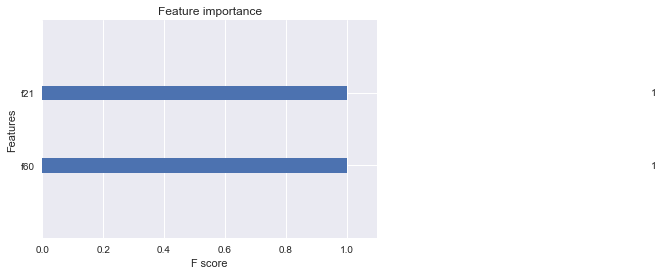

In [116]:
plot_importance(xgb_eq)

In [ ]:
plot_importance(xgb_biased)

In [ ]:
plot_importance(clf_eq)

In [ ]:
plot_importance(clf_biased)

In [109]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(penalty='l2', C=0.1, solver='newton-cg', multi_class='ovr', max_iter=500)
lr.fit(X_train, y_train)

In [119]:
train_cm = confusion_matrix(y_train, lr.predict(X_train))
train_precision, train_recall = cm_score(train_cm)
print(train_cm)
print(train_precision)
print(train_recall)

test_cm = confusion_matrix(y_test, lr.predict(X_test))
test_precision, test_recall = cm_score(test_cm)
print(test_cm)
print(test_precision)
print(test_recall)

# print(get_f1_score(test_cm))

KeyboardInterrupt: 